# Clustering RGB image features with PhenoGraph

#### This notebook uses the matrix of 672 features per single cell RGB cropped image to cluster the cells and identify which are red blood cells based on clustering pattern

## Importing

In [1]:
import warnings
# To ignore Pandas Future Warning
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import scanpy as sc
import pandas as pd
from matplotlib import pyplot as plt
import phenograph
import copy
from scipy import sparse
from sklearn.metrics import adjusted_rand_score
import seaborn as sns
%matplotlib inline

In [2]:
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
print("phenograph==", phenograph.__version__)
sc.settings.set_figure_params(dpi=80, facecolor='white')

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.3 scipy==1.9.1 pandas==1.5.0 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.10.1 pynndescent==0.5.7
phenograph== 1.5.7


In [3]:
from os import listdir
from os.path import isfile, join

### Read in feature matrix as csv

In [4]:
pt = 'P56'

In [5]:
# read in features from each fov
feats_dir = 'Normalized_RGB_feats/'
tables = [f for f in listdir(feats_dir) if isfile(join(feats_dir, f))]
tables.sort()

In [6]:
# create all-fov feats table
all_fovs = pd.read_csv(feats_dir + tables[0], index_col=0)

for i in range(1,len(tables)):
    data = pd.read_csv(feats_dir + tables[i], index_col=0)
    all_fovs = pd.concat([all_fovs, data])
    
all_fovs

0         1         2         3         4  \
P56_FOV01_cell_1     0.412951  2.561451  3.120644  2.464042  0.722097   
P56_FOV01_cell_2     0.421342  2.511641  3.113629  2.380988  0.659559   
P56_FOV01_cell_3     0.513237  2.497793  2.985347  2.517626  0.984588   
P56_FOV01_cell_4     0.454812  2.320824  3.072195  2.510095  0.733049   
P56_FOV01_cell_5     0.445658  2.290184  3.151314  2.496711  0.618898   
...                       ...       ...       ...       ...       ...   
P56_FOV25_cell_5487  0.425266  2.590341  3.098104  2.617624  0.673727   
P56_FOV25_cell_5488  0.401550  2.705409  3.097417  2.611556  0.697328   
P56_FOV25_cell_5490  0.400910  2.679401  3.120907  2.690382  0.573144   
P56_FOV25_cell_5491  0.412459  2.654203  3.108942  2.730542  0.537429   
P56_FOV25_cell_5492  0.416292  2.671224  3.056465  2.636549  0.588084   

                            5         6         7         8         9  ...  \
P56_FOV01_cell_1     0.483772  2.279626 -0.079514  1.016841  0.504575  ...   
P56_FOV01_cell_2     0.592287  2.217063 -0.097531  1.028470  0.657397  ...   
P56_FOV01_cell_3     0.557458  2.224652 -0.077075  1.217741  0.590884  ...   
P56_FOV01_cell_4     0.526225  2.221873 -0.145162  0.969109  0.451596  ...   
P56_FOV01_cell_5     0.517995  2.283777 -0.156806  0.993000  0.396975  ...   
...                       ...       ...       ...       ...       ...  ...   
P56_FOV25_cell_5487  0.533837  2.281008 -0.133753  0.992744  0.330195  ...   
P56_FOV25_cell_5488  0.441953  2.306333 -0.111651  0.886648  0.343037  ...   
P56_FOV25_cell_5490  0.380504  2.321491 -0.087489  0.847647  0.300080  ...   
P56_FOV25_cell_5491  0.369808  2.369433 -0.130413  0.789168  0.285878  ...   
P56_FOV25_cell_5492  0.380256  2.317316 -0.134817  0.817870  0.325095  ...   

                          662       663       664       665       666  \
P56_FOV01_cell_1     0.489821  0.059128  0.886625 -0.000119  1.796265   
P56_FOV01_cell_2     0.512424  0.129690  0.723608  0.021846  1.803649   
P56_FOV01_cell_3     0.654296  0.151059  0.184760  0.020365  1.865014   
P56_FOV01_cell_4     0.601111  0.192217  0.333408  0.076023  1.797345   
P56_FOV01_cell_5     0.525877  0.090863  0.280233  0.003131  1.759245   
...                       ...       ...       ...       ...       ...   
P56_FOV25_cell_5487  0.527269 -0.050472  0.185563  0.004249  1.774623   
P56_FOV25_cell_5488  0.499400 -0.046864  0.143876  0.003299  1.815713   
P56_FOV25_cell_5490  0.501827 -0.048554  0.222680 -0.006795  1.777512   
P56_FOV25_cell_5491  0.529693 -0.044670  0.126567 -0.020502  1.727467   
P56_FOV25_cell_5492  0.489389 -0.015302  0.147969  0.002643  1.809180   

                          667       668       669       670       671  
P56_FOV01_cell_1     0.347995  3.405382  0.120676  0.500273 -0.029530  
P56_FOV01_cell_2     0.212619  3.437262  0.072563  0.531672 -0.045534  
P56_FOV01_cell_3     0.638245  3.343181  0.949784  0.345000 -0.024154  
P56_FOV01_cell_4     0.300546  3.367466  0.449024  0.520056 -0.028888  
P56_FOV01_cell_5     0.156987  3.441068  0.130491  0.577073 -0.053676  
...                       ...       ...       ...       ...       ...  
P56_FOV25_cell_5487  0.161186  3.428770  0.063488  0.589789 -0.011446  
P56_FOV25_cell_5488  0.179780  3.451399 -0.032535  0.553534 -0.040938  
P56_FOV25_cell_5490  0.151862  3.411042 -0.037494  0.610688 -0.046807  
P56_FOV25_cell_5491  0.157942  3.430237 -0.054357  0.649472 -0.052086  
P56_FOV25_cell_5492  0.171734  3.446553 -0.036133  0.592395  0.007787  

[86344 rows x 672 columns]

In [7]:
# concatenate individual FOV feature tables as 1 large feature table
all_fovs.to_csv(pt + "_all_cell_RGB_features.csv", header=False)

In [8]:
# read in feature matrix as anndata object for clustering
adata = sc.read_csv(pt + "_all_cell_RGB_features.csv", first_column_names=True)
adata

AnnData object with n_obs × n_vars = 86344 × 672

In [9]:
adata.obs

Empty DataFrame
Columns: []
Index: [P56_FOV01_cell_1, P56_FOV01_cell_2, P56_FOV01_cell_3, P56_FOV01_cell_4, P56_FOV01_cell_5, P56_FOV01_cell_6, P56_FOV01_cell_7, P56_FOV01_cell_8, P56_FOV01_cell_9, P56_FOV01_cell_10, P56_FOV01_cell_11, P56_FOV01_cell_12, P56_FOV01_cell_13, P56_FOV01_cell_14, P56_FOV01_cell_15, P56_FOV01_cell_16, P56_FOV01_cell_17, P56_FOV01_cell_18, P56_FOV01_cell_19, P56_FOV01_cell_20, P56_FOV01_cell_21, P56_FOV01_cell_22, P56_FOV01_cell_23, P56_FOV01_cell_24, P56_FOV01_cell_25, P56_FOV01_cell_26, P56_FOV01_cell_27, P56_FOV01_cell_28, P56_FOV01_cell_29, P56_FOV01_cell_30, P56_FOV01_cell_31, P56_FOV01_cell_32, P56_FOV01_cell_33, P56_FOV01_cell_34, P56_FOV01_cell_35, P56_FOV01_cell_36, P56_FOV01_cell_37, P56_FOV01_cell_38, P56_FOV01_cell_39, P56_FOV01_cell_40, P56_FOV01_cell_41, P56_FOV01_cell_42, P56_FOV01_cell_43, P56_FOV01_cell_44, P56_FOV01_cell_45, P56_FOV01_cell_46, P56_FOV01_cell_47, P56_FOV01_cell_48, P56_FOV01_cell_49, P56_FOV01_cell_50, P56_FOV01_cell_51, P56_FOV01_cell_52, P56_FOV01_cell_53, P56_FOV01_cell_54, P56_FOV01_cell_55, P56_FOV01_cell_56, P56_FOV01_cell_57, P56_FOV01_cell_58, P56_FOV01_cell_59, P56_FOV01_cell_60, P56_FOV01_cell_61, P56_FOV01_cell_62, P56_FOV01_cell_63, P56_FOV01_cell_64, P56_FOV01_cell_65, P56_FOV01_cell_66, P56_FOV01_cell_67, P56_FOV01_cell_68, P56_FOV01_cell_69, P56_FOV01_cell_70, P56_FOV01_cell_71, P56_FOV01_cell_72, P56_FOV01_cell_73, P56_FOV01_cell_74, P56_FOV01_cell_75, P56_FOV01_cell_76, P56_FOV01_cell_77, P56_FOV01_cell_78, P56_FOV01_cell_79, P56_FOV01_cell_80, P56_FOV01_cell_81, P56_FOV01_cell_82, P56_FOV01_cell_83, P56_FOV01_cell_84, P56_FOV01_cell_85, P56_FOV01_cell_86, P56_FOV01_cell_87, P56_FOV01_cell_88, P56_FOV01_cell_89, P56_FOV01_cell_90, P56_FOV01_cell_91, P56_FOV01_cell_92, P56_FOV01_cell_93, P56_FOV01_cell_94, P56_FOV01_cell_95, P56_FOV01_cell_96, P56_FOV01_cell_97, P56_FOV01_cell_98, P56_FOV01_cell_99, P56_FOV01_cell_100, ...]

[86344 rows x 0 columns]

In [10]:
# load FOV metadata
FOV_metadata = pd.read_csv('/data/Zhaolab/1_AMLCosMx/Final_scripts/4_CellTyping/FOV_metadata.csv', index_col=0)
FOV_metadata

Timepoint Clinical outcome
P51_FOV01         A               PD
P51_FOV02         A               PD
P51_FOV03         A               PD
P51_FOV04         A               PD
P51_FOV05         A               PD
...             ...              ...
P58_FOV19         C               SD
P58_FOV20         C               SD
P58_FOV21         C               SD
P58_FOV22         C               SD
P58_FOV23         C               SD

[141 rows x 2 columns]

In [11]:
# get FOV and cell number from cell ID o

adata.obs['FOV'] = ''
adata.obs['cell_ID'] = 0
adata.obs['Timepoint'] = ''

for i in range(adata.obs.shape[0]):
    adata.obs['FOV'].iloc[i] = adata.obs.iloc[i].name[7:9]
    adata.obs['cell_ID'].iloc[i] = adata.obs.iloc[i].name[15:].replace('.png', '')
    adata.obs['Timepoint'].iloc[i] = FOV_metadata['Timepoint'].loc[adata.obs.iloc[i].name[0:9]]

adata.obs

/tmp/ipykernel_2586358/4186933571.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['FOV'].iloc[i] = adata.obs.iloc[i].name[7:9]
/tmp/ipykernel_2586358/4186933571.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['cell_ID'].iloc[i] = adata.obs.iloc[i].name[15:].replace('.png', '')


FOV cell_ID Timepoint
P56_FOV01_cell_1     01       1         A
P56_FOV01_cell_2     01       2         A
P56_FOV01_cell_3     01       3         A
P56_FOV01_cell_4     01       4         A
P56_FOV01_cell_5     01       5         A
...                  ..     ...       ...
P56_FOV25_cell_5487  25    5487         C
P56_FOV25_cell_5488  25    5488         C
P56_FOV25_cell_5490  25    5490         C
P56_FOV25_cell_5491  25    5491         C
P56_FOV25_cell_5492  25    5492         C

[86344 rows x 3 columns]

In [12]:
# save copy of complete anndata object
adata_all = adata

## Cluster Timepoint A FOVs for RBCs

In [45]:
tp = 'A'

In [21]:
# subset adata to just TPA
adata = adata_all[adata_all.obs['Timepoint'] == tp]
adata

View of AnnData object with n_obs × n_vars = 34980 × 672
    obs: 'FOV', 'cell_ID', 'Timepoint'

## Pre-Processing

### Log-Transformation

In [22]:
#Log-transform our dataset using the default Scanpy utility
adata_log1p = sc.pp.log1p(adata, copy = True)

### Principal Component Analysis (PCA)

In [23]:
#adata = adata_log1p # don't use log-scaled dataset
adata = sc.tl.pca(adata, n_comps = 50, copy = True)

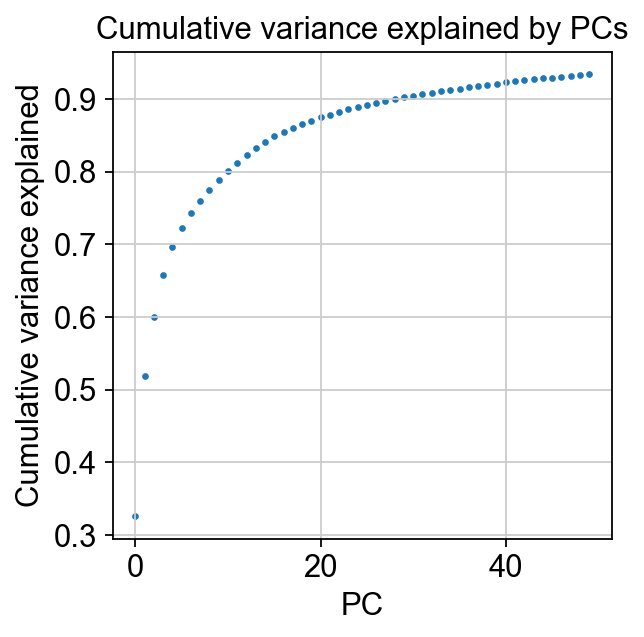

In [24]:
# Cumulative variance explained:
cml_var_explained = np.cumsum(adata.uns['pca']['variance_ratio'])
x = range(len(adata.uns['pca']['variance_ratio']))
y = cml_var_explained
plt.scatter(x, y, s=4)
plt.xlabel('PC')
plt.ylabel('Cumulative variance explained')
plt.title('Cumulative variance explained by PCs')
plt.show()

In [25]:
# set the minimum cumulative fraction of variance explained
min_cml_frac = 0.20
# find the number of PCs that together explain the minimal cum. fraction of variance
n_pcs = next(idx for idx,cml_frac in enumerate(cml_var_explained) if cml_frac > min_cml_frac)
print('Number of PCs that together explain a fraction of ' + str(min_cml_frac) + ' of the variance: ' + str(n_pcs))

Number of PCs that together explain a fraction of 0.2 of the variance: 0


## Clustering with PhenoGraph

### Running PhenoGraph

In [47]:
k = 5 # choose k, smaller values for finer-grained clustering
sc.settings.verbose = 0
communities, graph, Q = phenograph.cluster(pd.DataFrame(adata.obsm['X_pca']),k=k) # run PhenoGraph
# store the results in adata:
adata.obs['PhenoGraph_clusters'] = pd.Categorical(communities)
adata.uns['PhenoGraph_Q'] = Q
adata.uns['PhenoGraph_k'] = k

Finding 5 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 32.71371626853943 seconds
Jaccard graph constructed in 6.728572130203247 seconds
Wrote graph to binary file in 0.048087120056152344 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.94144
Louvain completed 21 runs in 6.810678958892822 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 50.31376242637634 seconds


In [54]:
# run clustering
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)
sc.tl.umap(adata)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


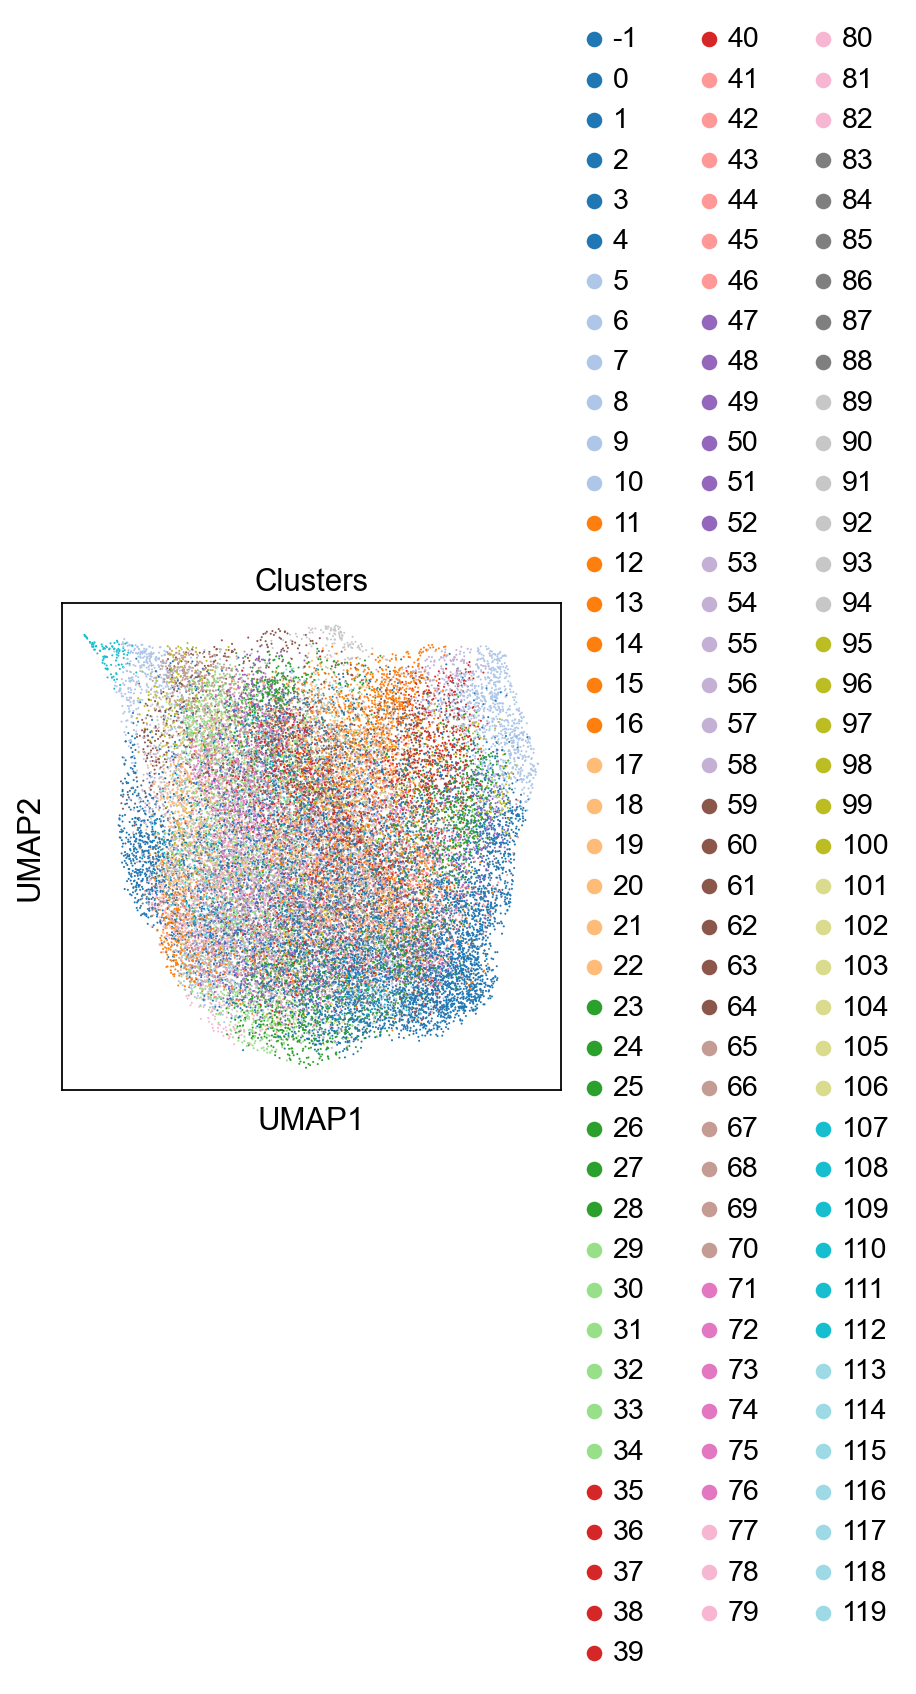

In [55]:
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'],
    palette='tab20',
    title=["Clusters"]
)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


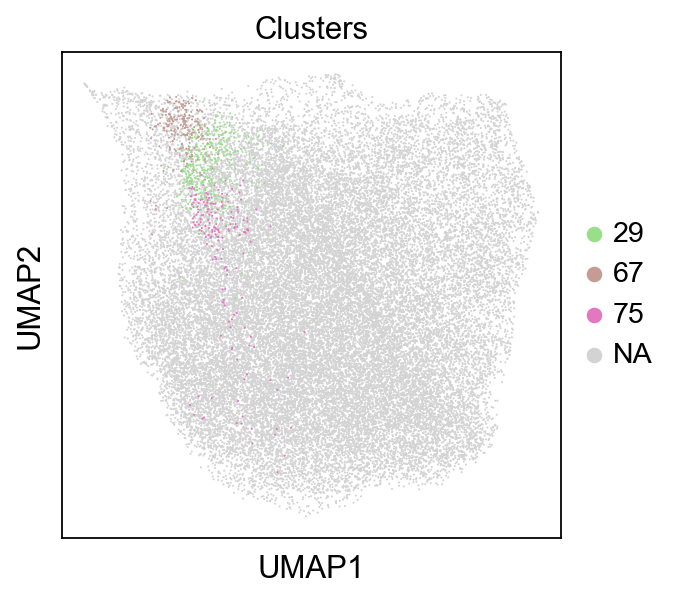

In [59]:
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'],
    palette='tab20',
    title=["Clusters"], groups=[29,67,75]
)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


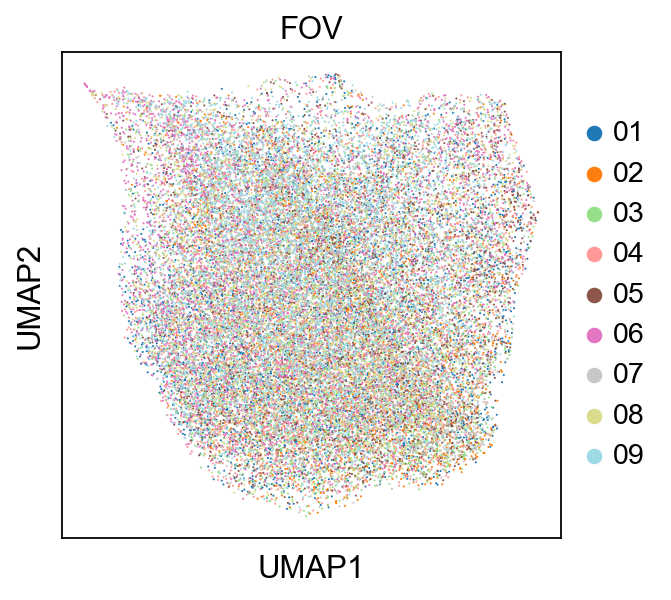

In [56]:
sc.pl.umap(
    adata, 
    color=['FOV'],
    palette='tab20', # 'palette' specifies the colormap to use)
    title=["FOV"]
)

In [57]:
# save dataframe of clustering results (adata.obs)
adata.obs.to_csv('TP' + tp + '/' + pt + tp + '_RGB_clusters.csv')

In [58]:
# save clustered data anndata object
adata_all.write_h5ad('TP' + tp + '/' + pt + tp + '_RGB_cell_features_clustered.h5ad')

## Cluster Timepoint B FOVs for RBCs

In [60]:
tp = 'B'

In [61]:
# subset adata to just TPA
adata = adata_all[adata_all.obs['Timepoint'] == tp]
adata

View of AnnData object with n_obs × n_vars = 24657 × 672
    obs: 'FOV', 'cell_ID', 'Timepoint'

## Pre-Processing

### Log-Transformation

In [62]:
#Log-transform our dataset using the default Scanpy utility
adata_log1p = sc.pp.log1p(adata, copy = True)

### Principal Component Analysis (PCA)

In [63]:
#adata = adata_log1p # don't use log-scaled dataset
adata = sc.tl.pca(adata, n_comps = 50, copy = True)

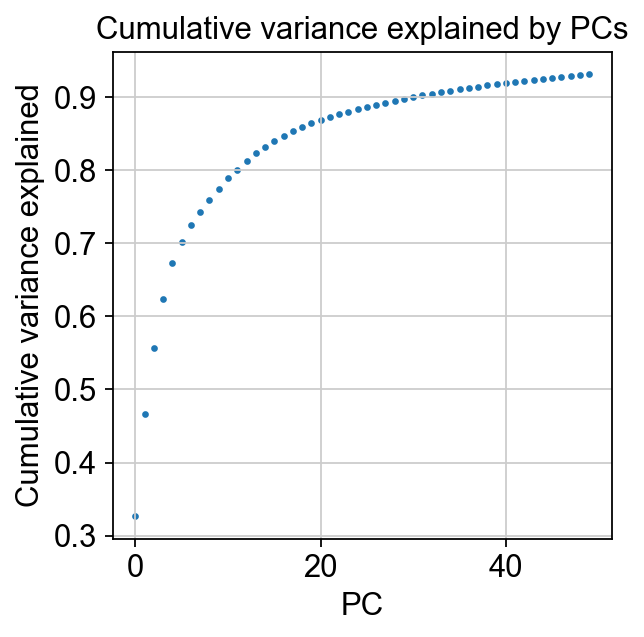

In [64]:
# Cumulative variance explained:
cml_var_explained = np.cumsum(adata.uns['pca']['variance_ratio'])
x = range(len(adata.uns['pca']['variance_ratio']))
y = cml_var_explained
plt.scatter(x, y, s=4)
plt.xlabel('PC')
plt.ylabel('Cumulative variance explained')
plt.title('Cumulative variance explained by PCs')
plt.show()

In [65]:
# set the minimum cumulative fraction of variance explained
min_cml_frac = 0.20
# find the number of PCs that together explain the minimal cum. fraction of variance
n_pcs = next(idx for idx,cml_frac in enumerate(cml_var_explained) if cml_frac > min_cml_frac)
print('Number of PCs that together explain a fraction of ' + str(min_cml_frac) + ' of the variance: ' + str(n_pcs))

Number of PCs that together explain a fraction of 0.2 of the variance: 0


## Clustering with PhenoGraph

### Running PhenoGraph

In [66]:
k = 15 # choose k, smaller values for finer-grained clustering
sc.settings.verbose = 0
communities, graph, Q = phenograph.cluster(pd.DataFrame(adata.obsm['X_pca']),k=k) # run PhenoGraph
# store the results in adata:
adata.obs['PhenoGraph_clusters'] = pd.Categorical(communities)
adata.uns['PhenoGraph_Q'] = Q
adata.uns['PhenoGraph_k'] = k

Finding 15 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 16.95332098007202 seconds
Jaccard graph constructed in 9.390894889831543 seconds
Wrote graph to binary file in 0.23061561584472656 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.761478
After 7 runs, maximum modularity is Q = 0.762674
Louvain completed 27 runs in 14.495891332626343 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 45.64769506454468 seconds


In [67]:
# run clustering
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)
sc.tl.umap(adata)

In [68]:
# read in clustered df
#adata = sc.read_h5ad("P56" + tp + "_RGB_cell_features_clustered.h5ad")
#adata

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


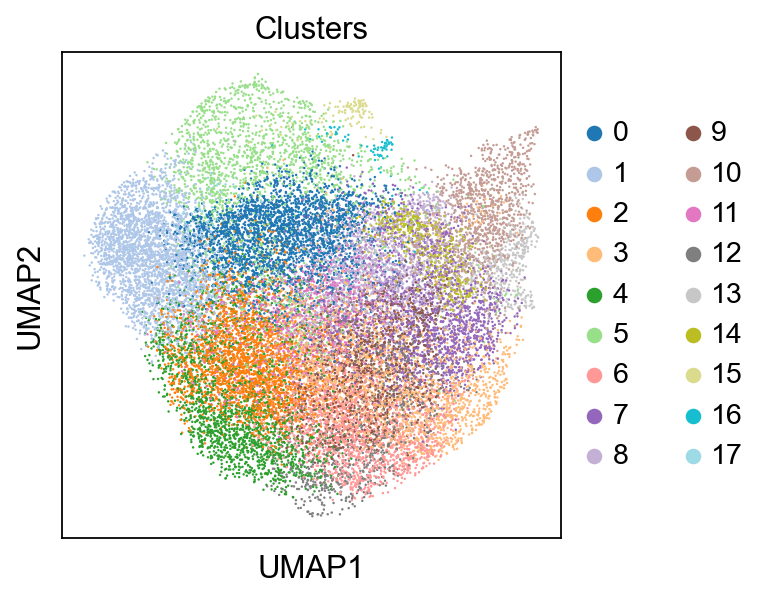

In [69]:
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'],
    palette='tab20',
    title=["Clusters"]
)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


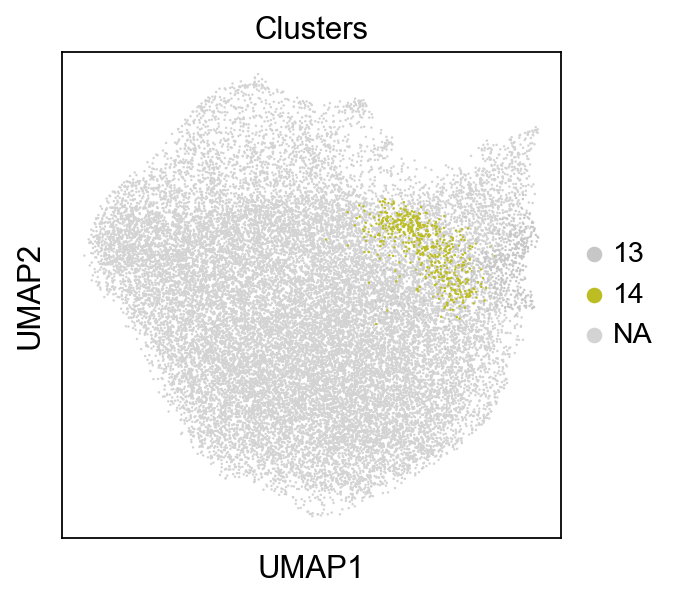

In [76]:
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'],
    palette='tab20',
    title=["Clusters"], groups=[13,14]
)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


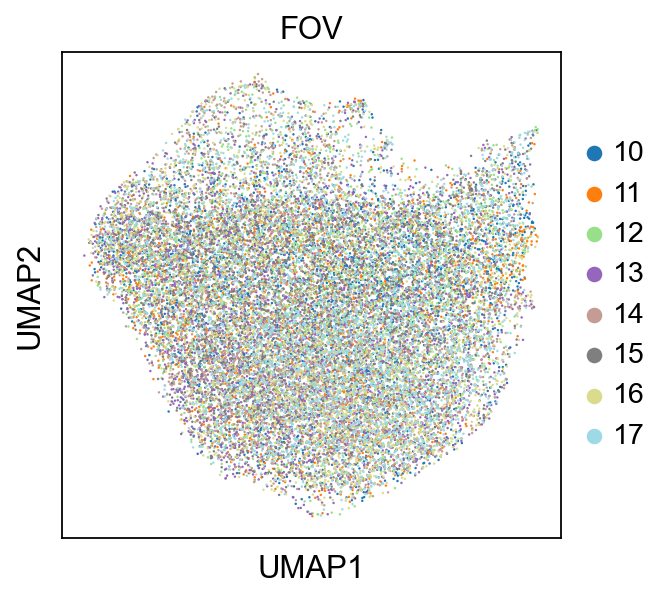

In [71]:
sc.pl.umap(
    adata, 
    color=['FOV'],
    palette='tab20', # 'palette' specifies the colormap to use)
    title=["FOV"]
)

In [72]:
# save dataframe of clustering results (adata.obs)
adata.obs.to_csv('TP' + tp + '/' + pt + tp + '_RGB_clusters.csv')

In [73]:
# save clustered data anndata object
adata_all.write_h5ad('TP' + tp + '/' + pt + tp + '_RGB_cell_features_clustered.h5ad')

## Cluster Timepoint C FOVs for RBCs

In [106]:
tp = 'C'

In [107]:
# subset adata to just TPA
adata = adata_all[adata_all.obs['Timepoint'] == tp]
adata

View of AnnData object with n_obs × n_vars = 26707 × 672
    obs: 'FOV', 'cell_ID', 'Timepoint'

## Pre-Processing

### Log-Transformation

In [108]:
#Log-transform our dataset using the default Scanpy utility
adata_log1p = sc.pp.log1p(adata, copy = True)

### Principal Component Analysis (PCA)

In [109]:
#adata = adata_log1p # don't use log-scaled dataset
adata = sc.tl.pca(adata, n_comps = 50, copy = True)

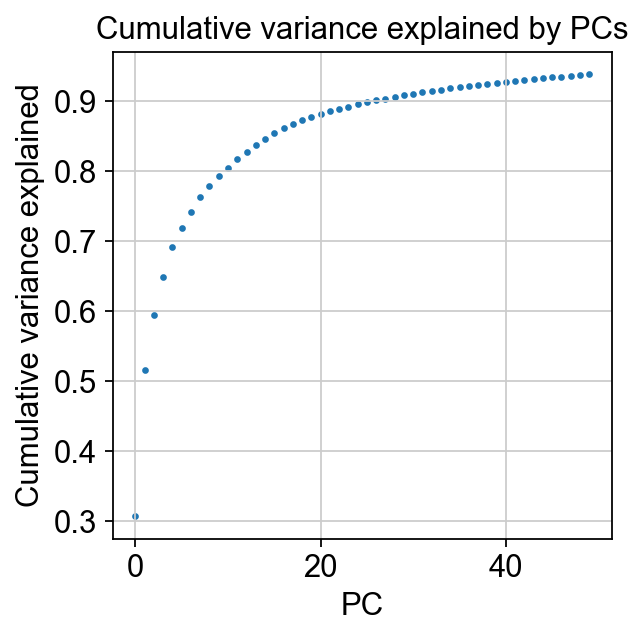

In [110]:
# Cumulative variance explained:
cml_var_explained = np.cumsum(adata.uns['pca']['variance_ratio'])
x = range(len(adata.uns['pca']['variance_ratio']))
y = cml_var_explained
plt.scatter(x, y, s=4)
plt.xlabel('PC')
plt.ylabel('Cumulative variance explained')
plt.title('Cumulative variance explained by PCs')
plt.show()

In [111]:
# set the minimum cumulative fraction of variance explained
min_cml_frac = 0.20
# find the number of PCs that together explain the minimal cum. fraction of variance
n_pcs = next(idx for idx,cml_frac in enumerate(cml_var_explained) if cml_frac > min_cml_frac)
print('Number of PCs that together explain a fraction of ' + str(min_cml_frac) + ' of the variance: ' + str(n_pcs))

Number of PCs that together explain a fraction of 0.2 of the variance: 0


## Clustering with PhenoGraph

### Running PhenoGraph

In [112]:
k = 5 # choose k, smaller values for finer-grained clustering
sc.settings.verbose = 0
communities, graph, Q = phenograph.cluster(pd.DataFrame(adata.obsm['X_pca']),k=k) # run PhenoGraph
# store the results in adata:
adata.obs['PhenoGraph_clusters'] = pd.Categorical(communities)
adata.uns['PhenoGraph_Q'] = Q
adata.uns['PhenoGraph_k'] = k

Finding 5 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 17.12250256538391 seconds
Jaccard graph constructed in 3.642768383026123 seconds
Wrote graph to binary file in 0.02480030059814453 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.939654
Louvain completed 21 runs in 2.9249119758605957 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 26.669083833694458 seconds


In [113]:
# run clustering
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)
sc.tl.umap(adata)

In [114]:
# read in clustered df
#adata = sc.read_h5ad("P56" + tp + "_RGB_cell_features_clustered.h5ad")
#adata

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


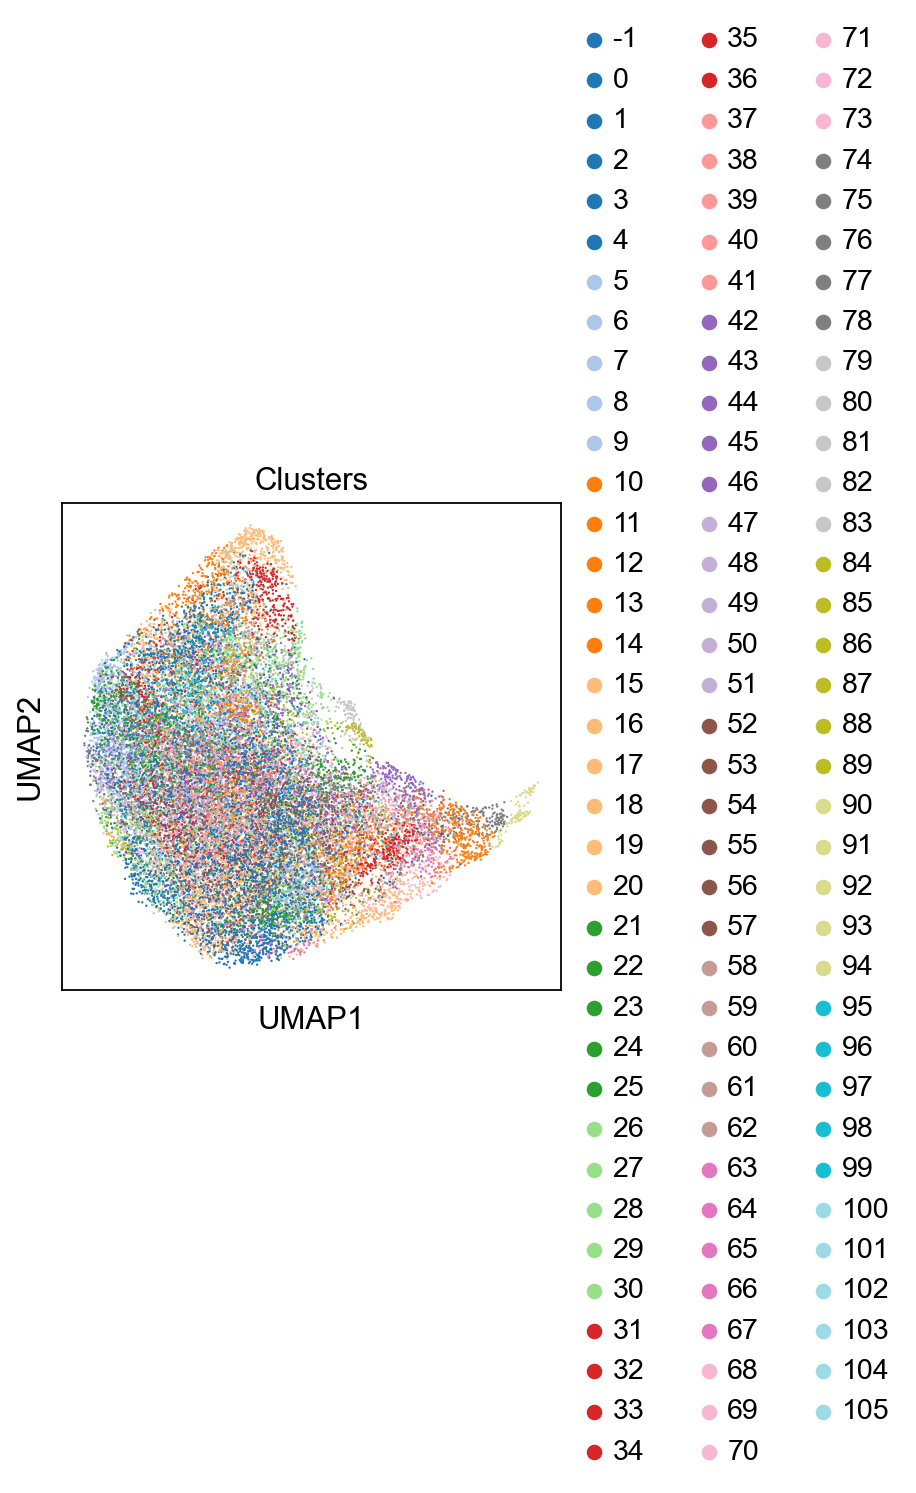

In [115]:
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'],
    palette='tab20',
    title=["Clusters"]
)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


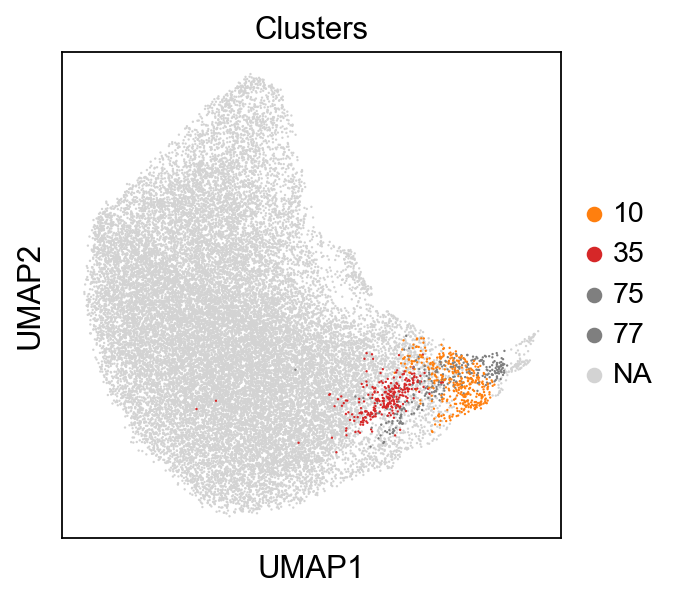

In [121]:
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'],
    palette='tab20',
    title=["Clusters"], groups=[10,35,75,77]
)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


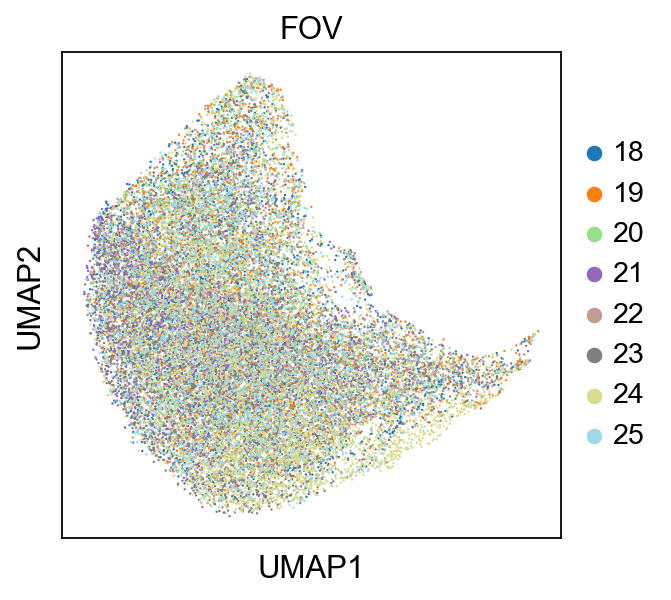

In [117]:
sc.pl.umap(
    adata, 
    color=['FOV'],
    palette='tab20', # 'palette' specifies the colormap to use)
    title=["FOV"]
)

In [118]:
# save dataframe of clustering results (adata.obs)
adata.obs.to_csv('TP' + tp + '/' + pt + tp + '_RGB_clusters.csv')

In [119]:
# save clustered data anndata object
adata_all.write_h5ad('TP' + tp + '/' + pt + tp + '_RGB_cell_features_clustered.h5ad')